#**Bachelor Thesis of Lucian Pemaj**

#**Quantum Speedup for High-Frequency Trading: A Multi-Dimensional Analysis Using Taylor Expansion and Optimization**



In [1]:
!pip uninstall qiskit-terra qiskit-aer qiskit-ignis qiskit-ibmq-provider qiskit-aqua
#!pip install qiskit 1.1.0

In [2]:
!python3 -m venv qiskit_env
!source qiskit_env/bin/activate
!pip install qiskit==1.1.0

Error: Command '['/content/qiskit_env/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: line 1: qiskit_env/bin/activate: No such file or directory
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.2 MB/s eta 0:00:00


In [3]:
# Quantum Computing Setup - Updated for latest Qiskit version
# !pip install qiskit matplotlib pandas numpy plotly networkx qiskit-aer qiskit-optimization qiskit-algorithms --upgrade qiskit-terra
!pip install qiskit-aer qiskit-algorithms qiskit-optimization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import time
import datetime
import networkx as nx

# Quantum libraries with updated imports
from qiskit import  QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import PhaseOracle, QFT
from qiskit.quantum_info import Statevector
from qiskit_aer import Aer

# For Grover's algorithm
from qiskit_algorithms import AmplificationProblem, Grover

# For optimization problems
try:
    # Try the newer approach first
    from qiskit_optimization import QuadraticProgram
    from qiskit_algorithms.minimum_eigensolvers import QAOA
    from qiskit_algorithms.optimizers import COBYLA
    from qiskit.primitives import Sampler
    USING_NEW_API = True
except ImportError:
    # Fall back to older version if needed
    from qiskit.optimization import QuadraticProgram
    from qiskit.algorithms import QAOA
    from qiskit.algorithms.optimizers import COBYLA
    from qiskit.utils import algorithm_globals, QuantumInstance
    USING_NEW_API = False

# Set random seed for reproducibility
np.random.seed(42)

print("Quantum computing environment set up successfully!")
print(f"Using Qiskit's {'new' if USING_NEW_API else 'legacy'} API")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.9/645.9 kB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 7.9 MB/s eta 0:00:00
  Created wheel for docplex: filename=docplex-2.29.245-py3-none-any.whl size=685439 sha256=4082a8a7924b3fe2cb19c41b150b1cf8f1fd116ef5e3559450627bb762b86369
  Stored in directory: /root/.cache/pip/wheels/be/37/0a/5f5f9ed14d637a664ad676493d55654f655a099c7016808739
Successfully built docplex
Quantum computing environment set up successfully!
Using Qiskit's new API


#In this section we are going to preprocess the data and clean them and change there scale and also implimenting some features as we can bellow in the code


1st we load the Parqeut data that we have on the drive to the working eviroment
 we then convert the timestamp that are in the unix time to Date-Time
  then we calculate the Mid-Price that is nothing more than the bid and the ask price and dived by 2 as shown in the Mid-Price Calculation
Then we scale the data using a function of min max scale to normalize all the data we calcualte the feautures for the data set of momentum and volatility

and we plot them



\
1. **Mid-Price Calculation:**


   \begin{equation}
   \text{MidPrice} = \frac{\text{askPrice} + \text{bidPrice}}{2}
   \end{equation}

2. **Min-Max Normalization:**
   Given a series \( x \), the normalization formula is:
   \begin{equation}
   x_{\text{normalized}} = \frac{x - \min(x)}{\max(x) - \min(x)}
   \end{equation}

3. **Momentum Calculation:**
   The momentum is calculated using the percentage change over \( n \) periods:
   \begin{equation}
   \text{Momentum} = \frac{\text{MidPrice}_t - \text{MidPrice}_{t-n}}{\text{MidPrice}_{t-n}}
   \end{equation}
   where \( n = 500 \).

4. **Volatility Calculation (Rolling Standard Deviation):**
   Volatility is computed using a rolling standard deviation over a window size \( w \):
   \begin{equation}
   \text{Volatility}_t = \sqrt{\frac{1}{w} \sum_{i=t-w+1}^{t} (\text{MidPrice}_i - \mu_t)^2}
   \end{equation}
   where \( \mu_t \) is the rolling mean:
   \begin{equation}
   \mu_t = \frac{1}{w} \sum_{i=t-w+1}^{t} \text{MidPrice}_i
   \end{equation}
   with \( w = 1000 \).
   


In [4]:
# This cell reuses your existing data loading and preprocessing
from google.colab import drive
drive.mount('/content/drive')

# Load the data
try:
    data = pd.read_parquet("/content/drive/MyDrive/Bachelor Thesis/AAPL_Tick.parquet")
    print("Data loaded from Google Drive.")
except FileNotFoundError:
    try:
        data = pd.read_parquet("AAPL_Tick.parquet")
        print("Data loaded from local file.")
    except FileNotFoundError:
        print("Error: AAPL_Tick.parquet not found in Google Drive or locally.")
        data = None

# Convert Unix timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')

# Sort by timestamp
data = data.sort_values(by='timestamp', ascending=True)

# Use mid-price as the price data
data['MidPrice'] = (data['askPrice'] + data['bidPrice']) / 2

# Store original values
original_mid_price = data['MidPrice'].copy()
price_min = original_mid_price.min()
price_max = original_mid_price.max()

# Normalize features (reusing your normalization function)
def normalize_series(series):
    """Normalize series using min-max scaling"""
    return (series - series.min()) / (series.max() - series.min())

# Normalize all features
time_normalized = normalize_series(np.arange(len(data)))
price_normalized = normalize_series(data['MidPrice'])
volume_normalized = normalize_series(data['askVolume'] + data['bidVolume'])

# Calculate and normalize additional features
n_momentum = 500
momentum = data['MidPrice'].pct_change(n_momentum).fillna(0)
momentum_normalized = normalize_series(momentum)

window_size = 1000
volatility = data['MidPrice'].rolling(window=window_size).std().fillna(0)
volatility_normalized = normalize_series(volatility)

# Define dimensions for analysis
dimensions = {
    '1D': ([time_normalized], [np.mean(time_normalized)]),
    '2D': ([time_normalized, volume_normalized],
           [np.mean(time_normalized), np.mean(volume_normalized)]),
    '3D': ([time_normalized, volume_normalized, momentum_normalized],
           [np.mean(time_normalized), np.mean(volume_normalized), np.mean(momentum_normalized)]),
    '4D': ([time_normalized, volume_normalized, momentum_normalized, volatility_normalized],
           [np.mean(time_normalized), np.mean(volume_normalized),
            np.mean(momentum_normalized), np.mean(volatility_normalized)])
}
print("Data loaded and preprocessed successfully.")
print(f"Data shape: {data.shape}")
print(f"Price range: ${price_min:.2f} - ${price_max:.2f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded from Google Drive.
Data loaded and preprocessed successfully.
Data shape: (2731749, 6)
Price range: $219.72 - $260.06


# Calculating the Mean Squared Error (MSE) for Taylor Approximation

In this section, we define a function to evaluate the goodness-of-fit for our Taylor series approximation. The core idea is to measure how closely the price predicted by the Taylor expansion matches the actual observed price data. We use the Mean Squared Error (MSE), a standard metric in regression and optimization problems, for this purpose.

1. **Taylor Series Approximation (2nd Order):**
   The price approximation around expansion point \( t_0 \):
   \begin{equation}
   P_{\text{approx}}(t) = a_0 + a_1 (t - t_0) + a_2 (t - t_0)^2
   \end{equation}

   Where:
   - \( P_approx(t) \) is the approximated price at time \( t \)
   - \( a_0 \) is the estimated price at \( t_0 \)
   - \( a_1 \) relates to the first derivative (rate of change) at \( t_0 \)
   - \( a_2 \) relates to the second derivative (curvature) at \( t_0 \)
   - \( t \) represents time points from the time_data
   - \( t_0 \) is the expansion point

2. **Error Calculation:**
   For each time point \( t_i \), we compute the difference between:
   \begin{equation}
   \text{Error} = P_{\text{approx}}(t_i) - P_{\text{actual}}(t_i)
   \end{equation}

3. **Mean Squared Error (MSE):**
   The squared errors are averaged over all \( N \) points:
   \begin{equation}
   \text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left( P_{\text{approx}}(t_i) - P_{\text{actual}}(t_i) \right)^2
   \end{equation}

   Where:
   - \( \text{MSE} \) measures the goodness-of-fit
   - \( N \) is the number of data points
   - \( P_{\text{actual}}(t_i) \) is the observed price at \( t_i \)

4. **Robustness Checks:**
   The function handles edge cases by returning:
   \begin{equation}
   \text{MSE} = \infty \quad \text{(if invalid parameters are detected)}
   \end{equation}



   # Mapping Bitstrings to Numerical Perturbation Values

This helper function converts binary strings to continuous values within a specified range, useful for optimization algorithms that work with binary representations.

1. **Integer Conversion:**
   Convert bitstring to base-10:
   \begin{equation}
   \text{int_val} = \text{binary_to_decimal}(bits\_str)
   \end{equation}

2. **Normalization:**
   Scale to [0,1] range:
   \begin{equation}
   x_{\text{norm}} = \frac{\text{int_val}}{2^n - 1}
   \end{equation}
   
   Where:
   - \( n \) is the bitstring length
   - \( 2^n - 1 \) is the maximum representable value

3. **Scaling to [-1,1]:**
   \begin{equation}
   x_{\text{scaled}} = 2 \times x_{\text{norm}} - 1
   \end{equation}

4. **Final Perturbation Value:**
   \begin{equation}
   \text{Perturbation} = \text{perturb_range} \times x_{\text{scaled}}
   \end{equation}
   
   Where:
   - \( perturb\_range \) sets the output range


In [5]:
# Helper function to calculate MSE
def calculate_mse(params, time_data, price_data, expansion_point):
    """Calculates MSE for a given set of Taylor coefficients."""
    a0, a1, a2 = params
    approx = a0 + a1 * (time_data - expansion_point) + a2 * (time_data - expansion_point)**2
    # Ensure approx and price_data have the same shape
    if approx.shape != price_data.shape:
         print(f"Warning: Shape mismatch in MSE calculation. Approx: {approx.shape}, Price: {price_data.shape}")
         # Attempt to align if possible (e.g., if one is scalar) - needs careful check
         if approx.size == 1:
             approx = np.full(price_data.shape, approx)
         elif price_data.size == 1:
              # This case is less likely for price data but handle defensively
              price_data = np.full(approx.shape, price_data)
         else:
              # If shapes are fundamentally incompatible, return a large error
              print("Error: Cannot reconcile shapes for MSE calculation.")
              return float('inf')

    mse = np.mean((approx - price_data)**2)
    if np.isnan(mse): # Check for NaN result
        print(f"Warning: MSE calculation resulted in NaN. Params: {params}")
        return float('inf') # Return large error if NaN
    return mse


# Helper function to map bits to a perturbation value
def bits_to_perturbation(bits_str, perturb_range):
    """Maps a bitstring to a perturbation value in [-perturb_range, +perturb_range]."""
    if not bits_str: # Handle empty bitstring case
        return 0.0
    max_val = 2**len(bits_str) - 1
    if max_val == 0: # Handle single bit case
        int_val = int(bits_str, 2)
        return perturb_range * (1.0 if int_val == 1 else -1.0) # Map 1 to +range, 0 to -range

    int_val = int(bits_str, 2)
    # Scale integer value to [0, 1], then to [-1, 1], then scale by perturb_range
    return perturb_range * (2 * (int_val / max_val) - 1)

# Hybrid Quantum-Classical Optimization for Taylor Coefficients (Normalized Data)

This section implements a hybrid optimization strategy to find the optimal coefficients $(a_0,a_1,a_2)$ for a second-order Taylor series approximation of normalized price data. The approach combines classical random search with quantum-inspired refinement.

## Overall Objective:
Minimize the Mean Squared Error (MSE) between Taylor approximation and normalized price data:
\begin{equation}
\min_{a_0,a_1,a_2} \left( \frac{1}{N} \sum_{i=1}^N \left( \left[a_0 + a_1(t_i^{\text{norm}} - t_0^{\text{norm}}) + a_2(t_i^{\text{norm}} - t_0^{\text{norm}})^2\right] - P_i^{\text{norm}} \right)^2 \right)
\end{equation}

**Where:**
- $P_i^{\text{norm}}$: Normalized price at $i$-th data point
- $t_i^{\text{norm}}$: Normalized time coordinate
- $t_0^{\text{norm}}$: Normalized expansion point
- $N$: Number of data points

## Methodology:

### 1. Initialization

- Time measurement begins

- Input validation: Checks $num\_qubits$ is divisible by 3

- Data sampling: Selects subset of size $sample\_size$ for efficient optimization


### 2. Classical Random Search (Initial Guess)
\begin{equation}
(a_0, a_1, a_2) \sim \text{Uniform}(param\_ranges)
\end{equation}

- Generates $classical\_samples$ random parameter sets

- Evaluates each using $calculate\_mse$ on sampled data

- Retains parameters with lowest MSE as $best\_classical\_params$


### 3. Quantum Refinement Loop
**Circuit Construction:**
\begin{equation}
|\psi\rangle = H^{\otimes n}|0\rangle = \frac{1}{\sqrt{2^n}}\sum_{j=0}^{2^n-1}|j\rangle
\end{equation}

- Applies Hadamard gates to all qubits

- Optional entanglement with CNOT gates

- Measures all qubits ($shots$ times)


**Parameter Update:**
\begin{equation}
\begin{pmatrix}
a_0' \\
a_1' \\
a_2'
\end{pmatrix}
=
\begin{pmatrix}
a_0 \\
a_1 \\
a_2
\end{pmatrix}
+
\begin{pmatrix}
\delta a_0 \\
\delta a_1 \\
\delta a_2
\end{pmatrix}
\end{equation}

- Maps measured bitstring to perturbations using $bits\_to\_perturbation$



### 4. Conditional Update
\begin{equation}
\text{Accept if: } MSE(a_0',a_1',a_2') < MSE(a_0,a_1,a_2)
\end{equation}

### 5. Final Application

- Applies optimized parameters to full dataset
- Calculates final performance metrics:

\begin{equation}
\text{MSE}_{\text{full}} = \frac{1}{N_{\text{full}}} \sum_{i=1}^{N_{\text{full}}} (P_{\text{approx}}(t_i) - P_{\text{actual}}(t_i))^2
\end{equation}
\item Returns:
\begin{itemize}
- Optimized Taylor series values
- Execution time
- Final parameters $(a_0, a_1, a_2)$


**Key Components:**
- $num\_qubits$: Total qubits used (divisible by 3)
- $classical\_samples$: Number of random trials
- $quantum\_iterations$: Refinement steps
- $perturb\_range$: Maximum parameter adjustment
- $sample\_size$: Subset size for efficient optimization


In [6]:
from qiskit_aer import AerSimulator

def quantum_1d_optimization_refined_hybrid(price_data_norm, time_data_norm,
                                           num_qubits=6, expansion_point_norm=0.5,
                                           classical_samples=1000, quantum_iterations=5,
                                           perturb_range=0.05):
    """
    Implements 1D optimization using a refined hybrid quantum approach on NORMALIZED data.

    Args:
        price_data_norm (np.array): Array of NORMALIZED price data.
        time_data_norm (np.array): Array of corresponding NORMALIZED time data.
        num_qubits (int): Number of qubits (should be divisible by 3).
        expansion_point_norm (float): The NORMALIZED point around which Taylor expansion is done.
        classical_samples (int): Number of samples for initial classical random search.
        quantum_iterations (int): Number of times to run the quantum perturbation step.
        perturb_range (float): Max absolute value for quantum-suggested parameter changes.

    Returns:
        tuple: (optimized_taylor_norm, execution_time, final_params)
               - optimized_taylor_norm: The optimized Taylor approximation on full NORMALIZED data.
               - execution_time: The time taken for the optimization.
               - final_params: The tuple (a0, a1, a2) of optimized coefficients.
    """
    start_time = time.time()

    if num_qubits < 3 or num_qubits % 3 != 0:
        raise ValueError("num_qubits must be at least 3 and divisible by 3")
    qubits_per_param = num_qubits // 3

    # Use a subset of data for faster evaluation during optimization
    sample_size = min(50000, len(price_data_norm))
    if sample_size == 0:
        print("Error: No data available for sampling.")
        return np.array([]), 0, (0,0,0) # Return empty/default values

    indices = np.linspace(0, len(price_data_norm)-1, sample_size, dtype=int)
    price_sample = price_data_norm[indices]
    time_sample = time_data_norm[indices]

    # --- Step 1: Classical Random Search for Initial Guess ---
    print("Performing initial classical random search...")
    best_classical_error = float('inf')
    # Initialize with mean price and zero slope/curvature for normalized data
    best_classical_params = (np.mean(price_sample), 0.0, 0.0)

    # Define reasonable search ranges for normalized data
    # a0 likely near mean (0.5), a1/a2 represent scaled slope/curvature
    a0_range = (0.0, 1.0) # Normalized price range
    a1_range = (-2.0, 2.0) # Slope can be steeper in normalized space
    a2_range = (-4.0, 4.0) # Curvature can be higher

    for i in range(classical_samples):
        # Sample random parameter values within defined ranges
        a0 = np.random.uniform(a0_range[0], a0_range[1])
        a1 = np.random.uniform(a1_range[0], a1_range[1])
        a2 = np.random.uniform(a2_range[0], a2_range[1])
        current_params = (a0, a1, a2)

        # Calculate error on the sample
        mse = calculate_mse(current_params, time_sample, price_sample, expansion_point_norm)

        if mse < best_classical_error:
            best_classical_error = mse
            best_classical_params = current_params



    print(f"Best classical guess: a0={best_classical_params[0]:.4f}, a1={best_classical_params[1]:.4f}, a2={best_classical_params[2]:.4f}, MSE: {best_classical_error:.6f}")

    # --- Step 2: Quantum Refinement Loop ---
    print(f"Performing {quantum_iterations} quantum refinement iterations...")
    current_best_params = best_classical_params
    current_best_error = best_classical_error
    backend = AerSimulator() # Use AerSimulator

    for i in range(quantum_iterations):
        # Create Quantum Circuit for proposing perturbations
        qc = QuantumCircuit(num_qubits, num_qubits) # Measure all qubits

        # Put qubits in superposition to explore perturbations
        qc.h(range(num_qubits))
        # Add some entanglement
        for q in range(num_qubits - 1):
            qc.cx(q, q + 1)
        if num_qubits > 1: # Add entanglement back to start if more than 1 qubit
             qc.cx(num_qubits - 1, 0)
        # Add measurement
        qc.measure(range(num_qubits), range(num_qubits))

        # Execute circuit
        try:
            t_qc = transpile(qc, backend)
            # Use a reasonable number of shots
            shots = 100 # Reduced shots for potentially faster simulation
            job = backend.run(t_qc, shots=shots)
            result = job.result()
            counts = result.get_counts()
            if not counts: # Handle case where simulation returns no counts
                 print(f"  Iter {i+1}: Quantum simulation returned no counts. Skipping perturbation.")
                 continue
        except Exception as e:
            print(f"  Iter {i+1}: Error during quantum circuit execution: {e}. Skipping perturbation.")
            continue


        # Get the most frequent outcome as the suggested perturbation direction
        most_frequent_bits = max(counts, key=counts.get)

        # Map bits to perturbations for a0, a1, a2
        bits_a0 = most_frequent_bits[0 : qubits_per_param]
        bits_a1 = most_frequent_bits[qubits_per_param : 2 * qubits_per_param]
        bits_a2 = most_frequent_bits[2 * qubits_per_param : 3 * qubits_per_param]

        # Adjust perturbation ranges if needed - these are relative changes
        delta_a0 = bits_to_perturbation(bits_a0, perturb_range * 0.5) # Smaller range for offset
        delta_a1 = bits_to_perturbation(bits_a1, perturb_range)      # Standard range for slope
        delta_a2 = bits_to_perturbation(bits_a2, perturb_range * 2.0) # Larger range for curvature

        # Calculate new parameters based on the perturbation
        perturbed_params = (
            current_best_params[0] + delta_a0,
            current_best_params[1] + delta_a1,
            current_best_params[2] + delta_a2
        )

        # Evaluate the perturbed parameters
        perturbed_mse = calculate_mse(perturbed_params, time_sample, price_sample, expansion_point_norm)

        # --- Step 3: Conditional Update ---
        if perturbed_mse < current_best_error:
            print(f"  Iter {i+1}: Quantum perturbation accepted. MSE improved from {current_best_error:.6f} to {perturbed_mse:.6f}")
            current_best_params = perturbed_params
            current_best_error = perturbed_mse
        else:
            print(f"  Iter {i+1}: Quantum perturbation rejected. MSE did not improve ({perturbed_mse:.6f} vs {current_best_error:.6f})")


    # --- Step 4: Final Application ---
    final_params = current_best_params
    opt_a0, opt_a1, opt_a2 = final_params

    # Apply optimized Taylor expansion to full NORMALIZED dataset
    optimized_taylor_norm = opt_a0 + opt_a1 * (time_data_norm - expansion_point_norm) + opt_a2 * (time_data_norm - expansion_point_norm)**2

    execution_time = time.time() - start_time

    print("-" * 30)
    print(f"Refined Hybrid Optimization completed in {execution_time:.4f} seconds")
    print(f"Final optimal parameters (normalized): a0={opt_a0:.4f}, a1={opt_a1:.4f}, a2={opt_a2:.4f}")
    print(f"Final MSE on sample data (normalized): {current_best_error:.6f}")

    # Calculate final MSE on full normalized data
    final_full_mse_norm = calculate_mse(final_params, time_data_norm, price_data_norm, expansion_point_norm)
    print(f"Final MSE on full data (normalized): {final_full_mse_norm:.6f}")
    print("-" * 30)

    return optimized_taylor_norm, execution_time, final_params

# Calculating Mean Squared Error (MSE) for Multi-Dimensional Taylor Approximation (Diagonal Quadratic)

This function evaluates the goodness-of-fit for a simplified multi-dimensional second-order Taylor expansion that approximates a target value (e.g., price) using multiple input features. The approximation includes constant, linear, and diagonal quadratic terms.

## Multi-Dimensional Taylor Approximation
\begin{equation}
P_{\text{approx}}(\mathbf{x}) = a_0 + \sum_{i=1}^d a_{1,i}(x_i - x_{0,i}) + \sum_{i=1}^d a_{2,ii}(x_i - x_{0,i})^2
\end{equation}

**Where:**
- $\mathbf{x} = (x_1, x_2, ..., x_d)$: Input feature vector ($d$ dimensions)
- $\mathbf{x_0} = (x_{0,1}, x_{0,2}, ..., x_{0,d})$: Expansion point
- $a_0$: Constant term (params[0])
- $a_{1,i}$: Linear coefficients (params[1] to params[$d$])
- $a_{2,ii}$: Diagonal quadratic coefficients (params[$d+1$] to params[$2d$])

## Parameter Handling

- Parameters flattened as: $(a_0, a_{1,1}, ..., a_{1,d}, a_{2,11}, ..., a_{2,dd})$
- Total parameters: $1 + 2d$ (verified by function)

## MSE Calculation
\begin{equation}
\text{MSE} = \frac{1}{N}\sum_{k=1}^N \left(P_{\text{approx}}(\mathbf{x_k}) - P_{\text{actual},k}\right)^2
\end{equation}

**Where:**
- $N$: Number of data points
- $\mathbf{x_k}$: Feature vector for $k$-th data point
- $P_{\text{actual},k}$: Observed value for $k$-th data point

## Robustness Checks

- Verifies parameter count matches $1 + 2d$
- Ensures $\mathbf{x_0}$ dimension matches input features
- Checks for shape compatibility before MSE computation
- Returns $\infty$ (float('inf')) for invalid cases:
\begin{equation}
\text{MSE} = \begin{cases}
\text{calculated value} & \text{if valid} \\
\infty & \text{if NaN or shape mismatch}
\end{cases}
\end{equation}


**Implementation Notes:**
1. Diagonal quadratic form omits cross-terms $(x_i-x_{0,i})(x_j-x_{0,j})$
2. Efficient vectorized computation for multi-dimensional inputs
3. Designed for optimization routines (returns $\infty$ for invalid cases)
4. Handles both single-point and batch evaluations


In [7]:
def calculate_mse_md(params, features_sample, price_sample, expansion_point):
    """
    Calculates MSE for multi-dimensional Taylor expansion (diagonal quadratic).

    Args:
        params (tuple): Tuple of parameters (a0, a1_1, ..., a1_d, a2_11, ..., a2_dd).
        features_sample (list): List of np.arrays for each feature sample.
        price_sample (np.array): Array of corresponding price sample.
        expansion_point (list): List/tuple of expansion points for each feature.

    Returns:
        float: Mean Squared Error.
    """
    ndim = len(features_sample)
    if len(params) != 1 + 2 * ndim:
        print(f"Error: Incorrect number of parameters ({len(params)}) for {ndim} dimensions. Expected {1 + 2 * ndim}.")
        return float('inf')
    if len(expansion_point) != ndim:
        print(f"Error: Expansion point length ({len(expansion_point)}) doesn't match number of features ({ndim}).")
        return float('inf')

    a0 = params[0]
    a1 = params[1 : 1 + ndim]
    a2_diag = params[1 + ndim : 1 + 2 * ndim]

    approx = np.full_like(price_sample, a0, dtype=np.float64) # Start with bias term

    # Add linear terms
    for i in range(ndim):
        dx_i = features_sample[i] - expansion_point[i]
        approx += a1[i] * dx_i

    # Add diagonal quadratic terms
    for i in range(ndim):
        dx_i = features_sample[i] - expansion_point[i]
        approx += a2_diag[i] * (dx_i ** 2)

    # Ensure shapes match before calculating MSE
    if approx.shape != price_sample.shape:
         print(f"Error: Shape mismatch in MD MSE. Approx: {approx.shape}, Price: {price_sample.shape}")
         return float('inf')

    mse = np.mean((approx - price_sample)**2)
    if np.isnan(mse):
        # print(f"Warning: MD MSE calculation resulted in NaN. Params: {params}")
        return float('inf')
    return mse

# Refined Hybrid Quantum-Classical Optimization for Multi-Dimensional Taylor Coefficients (Normalized Data)

## Optimization Objective
\begin{equation}
\min_{\mathbf{p}} \left( \frac{1}{N}\sum_{k=1}^N \left(P_{\text{approx}}(\mathbf{x}_k^{\text{norm}};\mathbf{p}) - P_{\text{actual},k}^{\text{norm}}\right)^2 \right)
\end{equation}

**Where:**
- $\mathbf{p} = (a_0, a_{1,1},...,a_{1,d}, a_{2,11},...,a_{2,dd})$: Parameter vector ($1+2d$ elements)
- $P_{\text{approx}}$: Diagonal quadratic Taylor approximation
- $\mathbf{x}_k^{\text{norm}}$: Normalized feature vector for $k$-th data point
- $d$: Number of feature dimensions

## Taylor Approximation Model
\begin{equation}
P_{\text{approx}}(\mathbf{x}^{\text{norm}};\mathbf{p}) = a_0 + \sum_{i=1}^d a_{1,i}(x_i^{\text{norm}} - x_{0,i}^{\text{norm}}) + \sum_{i=1}^d a_{2,ii}(x_i^{\text{norm}} - x_{0,i}^{\text{norm}}})^2
\end{equation}

## Methodology

### 1. Initialization Phase

- Feature extraction: $\mathbf{x}^{\text{norm}} \in \mathbb{R}^{N \times d}$, $\mathbf{x}_0^{\text{norm}} \in \mathbb{R}^d$
- Qubit allocation: $n_{\text{qubits}} = \text{num\_qubits\_factor} \times (1 + 2d)$
- Data sampling: ${sample\_size} \ll N$ for efficient optimization
\end{itemize}

### 2. Classical Random Search
\begin{equation}
\mathbf{p}_{\text{init}} \sim \begin{cases}
a_0 \in [0,1] \\
a_{1,i} \in [-2,2] \\
a_{2,ii} \in [-4,4]
\end{cases}
\end{equation}

- Evaluates $\text{classical\_samples}$ random parameter sets
- Retains $\mathbf{p}_{\text{classical}} = \argmin_{\mathbf{p}} \text{MSE}(\mathbf{p})$


### 3. Quantum Refinement Loop
**Circuit Construction:**
\begin{equation}
|\psi\rangle = \left(\bigotimes_{i=1}^{n_{\text{qubits}}} H_i\right)|0\rangle^{\otimes n_{\text{qubits}}}
\end{equation}

**Parameter Update:**
\begin{equation}
\mathbf{p}' = \mathbf{p}_{\text{current}} + \Delta\mathbf{p}
\end{equation}
where $\Delta\mathbf{p}$ components are scaled as:
\begin{align*}
\Delta a_0 &= \delta_0 \times 0.5 \\
\Delta a_{1,i} &= \delta_{1,i} \times 1.0 \\
\Delta a_{2,ii} &= \delta_{2,ii} \times 2.0
\end{align*}

### 4. Acceptance Criterion
\begin{equation}
\mathbf{p}_{\text{new}} = \begin{cases}
\mathbf{p}' & \text{if } \text{MSE}(\mathbf{p}') < \text{MSE}(\mathbf{p}_{\text{current}}) \\
\mathbf{p}_{\text{current}} & \text{otherwise}
\end{cases}
\end{equation}

### 5. Final Evaluation

- Full dataset application: $\text{MSE}_{\text{full}} = \text{MSE}(\mathbf{p}_{\text{final}})$
\item Performance metrics:
\begin{align*}
t_{\text{total}} &= t_{\text{end}} - t_{\text{start}} \\
\text{Improvement} &= \frac{\text{MSE}_{\text{initial}} - \text{MSE}_{\text{final}}}{\text{MSE}_{\text{initial}}} \times 100\%
\end{align*}


**Implementation Details:**
- Quantum circuit uses $n_{\text{qubits}}$ with:
  - Hadamard gates for superposition
  - CNOT ladder for entanglement
  - $n_{\text{shots}}$ measurements
- Perturbation mapping via ${bits\_to\_perturbation}$ function
- Parallel evaluation of candidate parameters
- Early stopping if $\text{MSE} < \epsilon_{\text{tol}}$
\end{itemize}

In [8]:
def quantum_md_optimization_refined_hybrid(price_data_norm, dimensions, dim_key,
                                           num_qubits_factor=2, # Qubits per feature pair (a1_i, a2_ii) + bias
                                           classical_samples=1000, quantum_iterations=5,
                                           perturb_range=0.1):
    """
    Implements multi-dimensional optimization using a refined hybrid quantum approach
    on NORMALIZED data, optimizing diagonal quadratic Taylor expansion.


    Args:
        price_data_norm (np.array): Array of NORMALIZED price data.
        dimensions (dict): Dictionary containing features and expansion points.
        dim_key (str): Key for the desired dimension (e.g., '2D', '3D').
        num_qubits_factor (int): Number of qubits to allocate per feature dimension (for a1_i, a2_ii)
                                 plus additional qubits for the bias term (a0). Min value 2.
        classical_samples (int): Number of samples for initial classical random search.
        quantum_iterations (int): Number of times to run the quantum perturbation step.
        perturb_range (float): Max absolute value factor for quantum-suggested parameter changes.

    Returns:
        tuple: (optimized_taylor_norm, execution_time)
               - optimized_taylor_norm: The optimized Taylor approximation on full NORMALIZED data.
               - execution_time: The time taken for the optimization.
    """
    start_time = time.time()
    print(f"\n--- Starting Refined Hybrid Quantum {dim_key} Optimization ---")

    # Get features and expansion point for selected dimension (ensure they are numpy arrays)
    features_norm_list, expansion_point_norm = dimensions[dim_key]
    features_norm = [feat.to_numpy() if isinstance(feat, pd.Series) else np.array(feat) for feat in features_norm_list]
    expansion_point_norm = np.array(expansion_point_norm)
    price_data_norm = price_data_norm.to_numpy() if isinstance(price_data_norm, pd.Series) else np.array(price_data_norm)

    ndim = len(features_norm)
    num_params = 1 + 2 * ndim # a0, d linear coeffs, d diagonal quadratic coeffs

    # Determine qubit allocation
    qubits_for_bias = max(2, num_qubits_factor // 2) # At least 2 qubits for bias
    qubits_per_feature = max(2, num_qubits_factor)   # At least 2 qubits per feature pair (a1_i, a2_ii)
    total_qubits = qubits_for_bias + ndim * qubits_per_feature

    print(f"Parameters: ndim={ndim}, num_params={num_params}, total_qubits={total_qubits} (bias={qubits_for_bias}, feat={qubits_per_feature})")
    print(f"classical_samples={classical_samples}, quantum_iterations={quantum_iterations}, perturb_range={perturb_range}")


    # Use a subset of data for faster evaluation during optimization
    sample_size = min(5000, len(price_data_norm))
    if sample_size == 0:
        print("Error: No data available for sampling.")
        return np.array([]), 0

    indices = np.linspace(0, len(price_data_norm)-1, sample_size, dtype=int)
    price_sample = price_data_norm[indices]
    features_sample = [feat[indices] for feat in features_norm]

    # --- Step 1: Classical Random Search for Initial Guess ---
    print("Performing initial classical random search...")
    best_classical_error = float('inf')
    # Initialize parameters (a0, a1_1..d, a2_11..dd)
    initial_guess_a0 = np.mean(price_sample) if price_sample.size > 0 else 0.5
    initial_params = tuple([initial_guess_a0] + [0.0] * ndim + [0.0] * ndim)
    best_classical_params = initial_params

    # Define reasonable search ranges for normalized data
    a0_range = (0.0, 1.0)
    a1_range = (-2.0, 2.0) # Linear coeffs
    a2_range = (-4.0, 4.0) # Diagonal quadratic coeffs

    for i in range(classical_samples):
        # Sample random parameter values
        a0 = np.random.uniform(a0_range[0], a0_range[1])
        a1 = np.random.uniform(a1_range[0], a1_range[1], size=ndim)
        a2_diag = np.random.uniform(a2_range[0], a2_range[1], size=ndim)
        current_params = tuple([a0] + list(a1) + list(a2_diag))

        # Calculate error on the sample
        mse = calculate_mse_md(current_params, features_sample, price_sample, expansion_point_norm)

        if mse < best_classical_error:
            best_classical_error = mse
            best_classical_params = current_params



    print(f"Best classical guess ({dim_key}): MSE={best_classical_error:.6f}")
    # print(f"Params: {best_classical_params}")

    # --- Step 2: Quantum Refinement Loop ---
    print(f"Performing {quantum_iterations} quantum refinement iterations for {dim_key}...")
    current_best_params = list(best_classical_params) # Convert to list for modification
    current_best_error = best_classical_error
    try:
        from qiskit_aer import AerSimulator
        backend = AerSimulator()
    except ImportError:
        print("Warning: AerSimulator not found, falling back.")
        from qiskit_aer import Aer
        backend = Aer.get_backend('qasm_simulator')


    for i in range(quantum_iterations):
        # Create Quantum Circuit for proposing perturbations
        qc = QuantumCircuit(total_qubits, total_qubits) # Measure all qubits

        # Put qubits in superposition
        qc.h(range(total_qubits))
        # Add entanglement (simple ladder)
        for q in range(total_qubits - 1):
            qc.cx(q, q + 1)
        if total_qubits > 1:
             qc.cx(total_qubits - 1, 0)
        # Add measurement
        qc.measure(range(total_qubits), range(total_qubits))

        # Execute circuit
        try:
            t_qc = transpile(qc, backend)
            shots = 100
            job = backend.run(t_qc, shots=shots)
            result = job.result()
            counts = result.get_counts()
            if not counts:
                 print(f"  Iter {i+1} ({dim_key}): Quantum simulation returned no counts. Skipping.")
                 continue
        except Exception as e:
            print(f"  Iter {i+1} ({dim_key}): Error during quantum circuit execution: {e}. Skipping.")
            continue

        # Get the most frequent outcome
        most_frequent_bits = max(counts, key=counts.get)

        # --- Map bits to perturbations ---
        perturbations = [0.0] * num_params
        bit_index = 0

        # Perturbation for a0 (bias)
        bits_a0 = most_frequent_bits[bit_index : bit_index + qubits_for_bias]
        perturbations[0] = bits_to_perturbation(bits_a0, perturb_range * 0.5) # Smaller range for bias
        bit_index += qubits_for_bias

        # Perturbations for a1_i and a2_ii pairs
        for k in range(ndim):
            bits_feature_k = most_frequent_bits[bit_index : bit_index + qubits_per_feature]
            # Split bits for a1_k and a2_kk (e.g., half/half)
            split_point = qubits_per_feature // 2
            bits_a1_k = bits_feature_k[:split_point]
            bits_a2_kk = bits_feature_k[split_point:]

            # Calculate perturbations (indices: 1..ndim for a1, ndim+1..2*ndim for a2)
            perturbations[1 + k] = bits_to_perturbation(bits_a1_k, perturb_range) # Linear term
            perturbations[1 + ndim + k] = bits_to_perturbation(bits_a2_kk, perturb_range * 2.0) # Quadratic term

            bit_index += qubits_per_feature

        # Calculate new parameters based on the perturbation
        perturbed_params = [current_best_params[j] + perturbations[j] for j in range(num_params)]

        # Evaluate the perturbed parameters
        perturbed_mse = calculate_mse_md(tuple(perturbed_params), features_sample, price_sample, expansion_point_norm)

        # --- Step 3: Conditional Update ---
        if perturbed_mse < current_best_error:
            print(f"  Iter {i+1} ({dim_key}): Quantum perturbation accepted. MSE improved from {current_best_error:.6f} to {perturbed_mse:.6f}")
            current_best_params = perturbed_params # Keep as list
            current_best_error = perturbed_mse
        else:
            # print(f"  Iter {i+1} ({dim_key}): Quantum perturbation rejected. MSE did not improve ({perturbed_mse:.6f} vs {current_best_error:.6f})")
            pass # Keep the previous best parameters

    # --- Step 4: Final Application ---
    final_params = tuple(current_best_params) # Convert back to tuple
    opt_a0 = final_params[0]
    opt_a1 = final_params[1 : 1 + ndim]
    opt_a2_diag = final_params[1 + ndim : 1 + 2 * ndim]

    # Apply optimized Taylor expansion to full NORMALIZED dataset
    optimized_taylor_norm = np.full_like(price_data_norm, opt_a0, dtype=np.float64)
    for i in range(ndim):
        dx_i = features_norm[i] - expansion_point_norm[i]
        optimized_taylor_norm += opt_a1[i] * dx_i
        optimized_taylor_norm += opt_a2_diag[i] * (dx_i ** 2)


    execution_time = time.time() - start_time

    print("-" * 30)
    print(f"Refined Hybrid {dim_key} Optimization completed in {execution_time:.4f} seconds")
    # print(f"Final optimal parameters ({dim_key}, normalized): {final_params}") # Optional: print params
    print(f"Final MSE on sample data ({dim_key}, normalized): {current_best_error:.6f}")

    # Calculate final MSE on full normalized data
    final_full_mse_norm = calculate_mse_md(final_params, features_norm, price_data_norm, expansion_point_norm)
    print(f"Final MSE on full data ({dim_key}, normalized): {final_full_mse_norm:.6f}")
    print("-" * 30)

    # Return the normalized result and execution time
    return optimized_taylor_norm, execution_time

In [9]:


# # Run 1D quantum optimization 1
# quantum_results_1d, quantum_time_1d = quantum_1d_optimization_refined_hybrid(
#     price_normalized, time_normalized, num_qubits=6, expansion_point_norm=np.mean(time_normalized)
# )

# Run 1D quantum optimization 2
quantum_results_1d, quantum_time_1d, _ = quantum_1d_optimization_refined_hybrid(
    price_normalized, time_normalized, num_qubits=6, expansion_point_norm=np.mean(time_normalized)
)

# Run multi-dimensional quantum optimization for 2D, 3D, and 4D
quantum_results = {}
quantum_times = {}

for dim in ['2D', '3D', '4D']:
    print(f"\nExecuting Quantum {dim} Optimization...")
    quantum_results[dim], quantum_times[dim] = quantum_md_optimization_refined_hybrid(
        price_normalized, dimensions, dim
    )

# Denormalize all quantum results
def denormalize_price(normalized_series):
    """Denormalize prices back to original scale"""
    return normalized_series * (price_max - price_min) + price_min

quantum_denormalized = {
    dim: denormalize_price(result)
    for dim, result in quantum_results.items()
}

# Include 1D results in the combined dictionary
if quantum_results_1d is not None:
    quantum_results['1D'] = quantum_results_1d
    quantum_times['1D'] = quantum_time_1d
    quantum_denormalized['1D'] = denormalize_price(quantum_results_1d)

# Calculate error metrics for all quantum results
print("\nQuantum Taylor Expansion Analysis:")
for dim in quantum_denormalized.keys():
    rmse = np.sqrt(np.mean((original_mid_price - quantum_denormalized[dim]) ** 2))
    mae = np.mean(np.abs(original_mid_price - quantum_denormalized[dim]))
    mape = np.mean(np.abs((original_mid_price - quantum_denormalized[dim]) / original_mid_price)) * 100

    print(f"\n{dim} Quantum Expansion:")
    print(f"RMSE: ${rmse:.2f}")
    print(f"MAE: ${mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Execution Time: {quantum_times[dim]:.4f} seconds")

Performing initial classical random search...
Best classical guess: a0=0.3112, a1=0.7085, a2=0.8462, MSE: 0.018405
Performing 5 quantum refinement iterations...
  Iter 1: Quantum perturbation accepted. MSE improved from 0.018405 to 0.018403
  Iter 2: Quantum perturbation rejected. MSE did not improve (0.020921 vs 0.018403)
  Iter 3: Quantum perturbation rejected. MSE did not improve (0.018602 vs 0.018403)
  Iter 4: Quantum perturbation rejected. MSE did not improve (0.020789 vs 0.018403)
  Iter 5: Quantum perturbation rejected. MSE did not improve (0.018407 vs 0.018403)
------------------------------
Refined Hybrid Optimization completed in 1.2997 seconds
Final optimal parameters (normalized): a0=0.3196, a1=0.6585, a2=0.8796
Final MSE on sample data (normalized): 0.018403
Final MSE on full data (normalized): 0.018402
------------------------------

Executing Quantum 2D Optimization...

--- Starting Refined Hybrid Quantum 2D Optimization ---
Parameters: ndim=2, num_params=5, total_qubit

# Classical Optimization Baseline for Taylor Coefficient Estimation

## Objective Function
For 1D case:
\begin{equation}
\text{MSE}(a_0,a_1,a_2) = \frac{1}{N}\sum_{i=1}^N \left(\left[a_0 + a_1(t_i^{\text{norm}} - t_0^{\text{norm}}) + a_2(t_i^{\text{norm}} - t_0^{\text{norm}})^2\right] - P_i^{\text{norm}}\right)^2
\end{equation}

For multi-dimensional case:
\begin{equation}
\text{MSE}(\mathbf{p}) = \frac{1}{N}\sum_{k=1}^N \left(\left[a_0 + \sum_{i=1}^d a_{1,i}(x_{k,i}^{\text{norm}} - x_{0,i}^{\text{norm}}) + \sum_{i=1}^d a_{2,ii}(x_{k,i}^{\text{norm}} - x_{0,i}^{\text{norm}})^2\right] - P_k^{\text{norm}}\right)^2
\end{equation}

## Optimization Procedure

### 1. Initialization

- Select MSE function based on dimension $d$
- Set initial parameters:
\begin{equation}
\mathbf{p}_0 = \begin{cases}
\bar{P}^{\text{norm}} & \text{for } a_0 \\
0 & \text{for all } a_{1,i}, a_{2,ii}
\end{cases}
\end{equation}


### 2. L-BFGS-B Optimization
\begin{equation}
\mathbf{p}^* = \argmin_{\mathbf{p}} \text{MSE}(\mathbf{p}) \quad \text{using L-BFGS-B method}
\end{equation}

**Configuration:**

- Maximum iterations: ${maxiter} = 1000$
- Gradient tolerance: ${gtol} = 1\times10^{-5}$
- Line search parameters: ${ftol} = 1\times10^{-7}$


## Error Metrics Calculation

### 1. Denormalization
\begin{equation}
P^{\text{approx}} = \text{denormalize\_price}(P^{\text{approx,norm}})
\end{equation}

### 2. Alignment and Validation

- Remove NaN/inf values
- Align time indices
- Calculate valid sample size $N_{\text{valid}}$


### 3. Error Metrics
\begin{align*}
\text{RMSE} &= \sqrt{\frac{1}{N_{\text{valid}}}\sum_{k\in\text{valid}}(P_k^{\text{actual}} - P_k^{\text{approx}})^2} \\
\text{MAE} &= \frac{1}{N_{\text{valid}}}\sum_{k\in\text{valid}}|P_k^{\text{actual}} - P_k^{\text{approx}}| \\
\text{MAPE} &= \frac{100\%}{N_{\text{valid}}}\sum_{k\in\text{valid}}\left|\frac{P_k^{\text{actual}} - P_k^{\text{approx}}}{P_k^{\text{actual}} + \epsilon}\right|
\end{align*}

## Performance Comparison

### Quantum vs Classical Comparison Table


**Key:**

- Improvement $> 0\%$ indicates quantum superiority
- Speedup $> 1$ indicates quantum was faster
- All metrics computed on identical data points


In [10]:

import time
import numpy as np
import pandas as pd
import scipy.optimize as optimize



def calculate_mse(params, time_data, price_data, expansion_point):
    """Calculates MSE for a given set of Taylor coefficients (1D)."""
    a0, a1, a2 = params
    approx = a0 + a1 * (time_data - expansion_point) + a2 * (time_data - expansion_point)**2
    if approx.shape != price_data.shape:
         if approx.size == 1: approx = np.full(price_data.shape, approx)
         elif price_data.size == 1: price_data = np.full(approx.shape, price_data)
         else: return float('inf') # Incompatible shapes
    mse = np.mean((approx - price_data)**2)
    return mse if not np.isnan(mse) else float('inf')

def calculate_mse_md(params, features_sample, price_sample, expansion_point):
    """Calculates MSE for multi-dimensional Taylor expansion (diagonal quadratic)."""
    ndim = len(features_sample)
    if len(params) != 1 + 2 * ndim: return float('inf') # Incorrect param count
    if len(expansion_point) != ndim: return float('inf') # Mismatched expansion point

    a0 = params[0]
    a1 = params[1 : 1 + ndim]
    a2_diag = params[1 + ndim : 1 + 2 * ndim]
    approx = np.full_like(price_sample, a0, dtype=np.float64)
    for i in range(ndim):
        dx_i = features_sample[i] - expansion_point[i]
        approx += a1[i] * dx_i
        approx += a2_diag[i] * (dx_i ** 2)
    if approx.shape != price_sample.shape: return float('inf') # Shape mismatch
    mse = np.mean((approx - price_sample)**2)
    return mse if not np.isnan(mse) else float('inf')

# --- Fair Classical Baseline Function ---

def classical_optimization_baseline(price_data_norm, features_norm, expansion_point_norm, ndim):
    """
    Performs classical optimization to find the best Taylor coefficients
    by minimizing MSE, matching the quantum method's objective.
    """
    print(f"--- Starting Classical Optimization Baseline ({ndim}D) ---")
    if ndim == 1:
        mse_func = calculate_mse
        num_params = 3
        initial_guess = [np.mean(price_data_norm), 0.0, 0.0]
        args = (features_norm[0], price_data_norm, expansion_point_norm[0])
    else:
        mse_func = calculate_mse_md
        num_params = 1 + 2 * ndim
        initial_guess = [np.mean(price_data_norm)] + [0.0] * ndim + [0.0] * ndim
        args = (features_norm, price_data_norm, expansion_point_norm)

    print(f"Optimizing {num_params} parameters using scipy.optimize.minimize...")
    result = optimize.minimize(
        fun=mse_func, x0=initial_guess, args=args,
        method='L-BFGS-B', options={'disp': False, 'maxiter': 500}
    )
    if not result.success:
        print(f"Warning: Classical optimization ({ndim}D) did not converge. Message: {result.message}")

    optimized_params = result.x
    final_mse = result.fun
    print(f"Classical optimization complete. Final MSE: {final_mse:.6f}")

    # Calculate the final approximation using the optimized parameters
    if ndim == 1:
        opt_a0, opt_a1, opt_a2 = optimized_params
        optimized_taylor_norm = opt_a0 + opt_a1 * (features_norm[0] - expansion_point_norm[0]) + opt_a2 * (features_norm[0] - expansion_point_norm[0])**2
    else:
        opt_a0 = optimized_params[0]
        opt_a1 = optimized_params[1 : 1 + ndim]
        opt_a2_diag = optimized_params[1 + ndim : 1 + 2 * ndim]
        optimized_taylor_norm = np.full_like(price_data_norm, opt_a0, dtype=np.float64)
        for i in range(ndim):
            dx_i = features_norm[i] - expansion_point_norm[i]
            optimized_taylor_norm += opt_a1[i] * dx_i
            optimized_taylor_norm += opt_a2_diag[i] * (dx_i ** 2)

    return optimized_taylor_norm # Return only the approximation array

# --- Run Fair Classical Optimization Baseline ---

classical_results = {}
classical_times = {}

print("\n--- Running Fair Classical Optimization Baselines ---")


price_normalized_np = price_normalized.to_numpy() if isinstance(price_normalized, pd.Series) else np.array(price_normalized)

for dim_key, (features_norm_list, expansion_point_norm) in dimensions.items():
    start_time = time.time()

    features_norm_np = [feat.to_numpy() if isinstance(feat, pd.Series) else np.array(feat) for feat in features_norm_list]
    expansion_point_np = np.array(expansion_point_norm)

    try:
        ndim = int(dim_key[0])
        if ndim != len(features_norm_np): raise ValueError("Dim key mismatch")
    except (ValueError, IndexError):
        print(f"Error: Invalid dimension key '{dim_key}'. Skipping classical baseline.")
        classical_results[dim_key] = np.full_like(price_normalized_np, np.nan) # Store NaN to avoid errors later
        classical_times[dim_key] = 0
        continue

    # Call the new baseline function
    classical_approx_norm = classical_optimization_baseline(
        price_normalized_np,
        features_norm_np,
        expansion_point_np,
        ndim
    )

    # Store results
    classical_results[dim_key] = classical_approx_norm
    classical_times[dim_key] = time.time() - start_time

    print(f"Classical Baseline ({dim_key}) completed in {classical_times[dim_key]:.4f} seconds.")
    print("-" * 20)


# Denormalize classical results
classical_denormalized = {
    key: denormalize_price(value)
    for key, value in classical_results.items()
    # Add a check to handle potential NaNs from skipped dimensions
    if not np.isnan(value).all()
}

# Calculate error metrics for classical results
print("\nClassical Optimization Baseline Analysis:")
# Use classical_denormalized.keys() to iterate only over successfully computed dimensions
for dim in classical_denormalized.keys():
    # Add length check and alignment if necessary (important!)
    len_diff = len(original_mid_price) - len(classical_denormalized[dim])
    if len_diff > 0:
        target_price = original_mid_price[len_diff:]
        print(f"Warning: Aligning original price length for {dim} classical comparison.")
    elif len_diff < 0:
        target_price = original_mid_price
        print(f"Warning: Classical approximation for {dim} is longer than original price. Comparison might be inaccurate.")
    else:
        target_price = original_mid_price

    if len(target_price) == len(classical_denormalized[dim]):
        # Ensure no NaNs in the slice being compared
        valid_indices = ~np.isnan(target_price) & ~np.isnan(classical_denormalized[dim])
        if np.sum(valid_indices) == 0:
             print(f"\nError: No valid data points for comparison for {dim}. Skipping metrics.")
             continue

        target_price_valid = target_price[valid_indices]
        classical_denorm_valid = classical_denormalized[dim][valid_indices]

        rmse = np.sqrt(np.mean((target_price_valid - classical_denorm_valid) ** 2))
        mae = np.mean(np.abs(target_price_valid - classical_denorm_valid))
        # Add epsilon to avoid division by zero/warnings in MAPE
        mape = np.mean(np.abs((target_price_valid - classical_denorm_valid) / (target_price_valid + 1e-10))) * 100

        print(f"\n{dim} Classical Baseline:") # Updated Title
        print(f"RMSE: ${rmse:.4f}") # Increased precision
        print(f"MAE: ${mae:.4f}")  # Increased precision
        print(f"MAPE: {mape:.4f}%") # Increased precision
        print(f"Execution Time: {classical_times[dim]:.4f} seconds")
    else:
         print(f"\nError: Length mismatch for {dim} classical comparison after alignment. Original: {len(target_price)}, Approx: {len(classical_denormalized[dim])}. Skipping metrics.")


# Create side-by-side comparison tables
comparison_data = []

# Iterate through dimensions common to both quantum and classical results
# Use set intersection to handle cases where one might have failed/skipped
common_dims = set(quantum_denormalized.keys()) & set(classical_denormalized.keys())

for dim in common_dims:
    # Add similar length checks and NaN handling for comparison metrics
    len_diff_q = len(original_mid_price) - len(quantum_denormalized[dim])
    len_diff_c = len(original_mid_price) - len(classical_denormalized[dim])

    # Align original price based on the *longer* difference if needed
    max_len_diff = max(len_diff_q, len_diff_c, 0)
    if max_len_diff > 0:
        target_price = original_mid_price[max_len_diff:]
        print(f"Warning: Aligning original price length for {dim} comparison table.")
    else:
        target_price = original_mid_price

    # Ensure lengths match after potential alignment
    if len(target_price) == len(quantum_denormalized[dim]) and len(target_price) == len(classical_denormalized[dim]):
        valid_indices = ~np.isnan(target_price) & ~np.isnan(quantum_denormalized[dim]) & ~np.isnan(classical_denormalized[dim])
        if np.sum(valid_indices) == 0:
             print(f"Error: No valid common data points for comparison table for {dim}. Skipping row.")
             continue

        target_price_valid = target_price[valid_indices]
        quantum_denorm_valid = quantum_denormalized[dim][valid_indices]
        classical_denorm_valid = classical_denormalized[dim][valid_indices]

        q_rmse = np.sqrt(np.mean((target_price_valid - quantum_denorm_valid) ** 2))
        q_mae = np.mean(np.abs(target_price_valid - quantum_denorm_valid))
        q_mape = np.mean(np.abs((target_price_valid - quantum_denorm_valid) / (target_price_valid + 1e-10))) * 100

        c_rmse = np.sqrt(np.mean((target_price_valid - classical_denorm_valid) ** 2))
        c_mae = np.mean(np.abs(target_price_valid - classical_denorm_valid))
        c_mape = np.mean(np.abs((target_price_valid - classical_denorm_valid) / (target_price_valid + 1e-10))) * 100

        q_time = quantum_times[dim]
        c_time = classical_times[dim]

        # Calculate speedup (>1 means quantum is faster)
        speedup = c_time / q_time if q_time > 0 else float('inf')

        # Determine if quantum is better in each metric
        rmse_better = q_rmse < c_rmse
        mae_better = q_mae < c_mae
        mape_better = q_mape < c_mape
        time_better = q_time < c_time

        comparison_data.append({
            'Dimension': dim,
            'Classical RMSE': c_rmse,
            'Quantum RMSE': q_rmse,
            'RMSE Improvement': (c_rmse - q_rmse) / c_rmse * 100 if c_rmse > 0 else 0,
            'Classical MAE': c_mae,
            'Quantum MAE': q_mae,
            'MAE Improvement': (c_mae - q_mae) / c_mae * 100 if c_mae > 0 else 0,
            'Classical MAPE': c_mape,
            'Quantum MAPE': q_mape,
            'MAPE Improvement': (c_mape - q_mape) / c_mape * 100 if c_mape > 0 else 0,
            'Classical Time': c_time,
            'Quantum Time': q_time,
            'Speedup': speedup,
            'RMSE Better': rmse_better,
            'MAE Better': mae_better,
            'MAPE Better': mape_better,
            'Time Better': time_better
        })
    else:
        print(f"Error: Length mismatch for {dim} comparison table after alignment. Skipping row.")


# Only create DataFrame if comparison_data is not empty
if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print("\nComparison of Classical vs. Quantum Methods:")
    # Select columns to display - adjust as needed
    display_cols = ['Dimension', 'Classical RMSE', 'Quantum RMSE', 'RMSE Improvement',
                    'Classical Time', 'Quantum Time', 'Speedup']
    # Ensure all display columns exist before printing
    display_cols = [col for col in display_cols if col in comparison_df.columns]
    print(comparison_df[display_cols].to_string(float_format="%.4f")) # Format floats for better readability
else:
    print("\nComparison table could not be generated due to errors or lack of common dimensions.")




--- Running Fair Classical Optimization Baselines ---
--- Starting Classical Optimization Baseline (1D) ---
Optimizing 3 parameters using scipy.optimize.minimize...
Classical optimization complete. Final MSE: 0.013407
Classical Baseline (1D) completed in 5.7625 seconds.
--------------------
--- Starting Classical Optimization Baseline (2D) ---
Optimizing 5 parameters using scipy.optimize.minimize...
Classical optimization complete. Final MSE: 0.013002
Classical Baseline (2D) completed in 13.9996 seconds.
--------------------
--- Starting Classical Optimization Baseline (3D) ---
Optimizing 7 parameters using scipy.optimize.minimize...
Classical optimization complete. Final MSE: 0.012981
Classical Baseline (3D) completed in 38.3299 seconds.
--------------------
--- Starting Classical Optimization Baseline (4D) ---
Optimizing 9 parameters using scipy.optimize.minimize...
Classical optimization complete. Final MSE: 0.012979
Classical Baseline (4D) completed in 104.2090 seconds.
----------

In [11]:
# Create comprehensive visualizations comparing classical and quantum approaches
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1. Execution Time Comparison
def plot_execution_times():
    dimensions = list(quantum_times.keys())
    c_times = [classical_times[dim] for dim in dimensions]
    q_times = [quantum_times[dim] for dim in dimensions]

    fig = go.Figure(data=[
        go.Bar(name='Classical', x=dimensions, y=c_times, marker_color='blue'),
        go.Bar(name='Quantum', x=dimensions, y=q_times, marker_color='red')
    ])

    fig.update_layout(
        title='Execution Time Comparison: Classical vs. Quantum',
        xaxis_title='Dimensions',
        yaxis_title='Time (seconds)',
        barmode='group',
        legend_title='Method',
        font=dict(size=12)
    )

    return fig

# 2. Accuracy Comparison (RMSE)
def plot_accuracy_comparison():
    dimensions = list(quantum_denormalized.keys())
    c_rmse = [np.sqrt(np.mean((original_mid_price - classical_denormalized[dim]) ** 2)) for dim in dimensions]
    q_rmse = [np.sqrt(np.mean((original_mid_price - quantum_denormalized[dim]) ** 2)) for dim in dimensions]

    fig = go.Figure(data=[
        go.Bar(name='Classical', x=dimensions, y=c_rmse, marker_color='blue'),
        go.Bar(name='Quantum', x=dimensions, y=q_rmse, marker_color='red')
    ])

    fig.update_layout(
        title='RMSE Comparison: Classical vs. Quantum',
        xaxis_title='Dimensions',
        yaxis_title='RMSE ($)',
        barmode='group',
        legend_title='Method',
        font=dict(size=12)
    )

    return fig

# 3. Speedup Analysis
def plot_speedup_analysis():
    dimensions = list(quantum_times.keys())
    speedups = [classical_times[dim]/quantum_times[dim] if quantum_times[dim] > 0 else 0 for dim in dimensions]

    fig = go.Figure(data=[
        go.Bar(
            x=dimensions,
            y=speedups,
            marker_color=['green' if s > 1 else 'red' for s in speedups]
        )
    ])

    fig.add_shape(
        type="line",
        x0=-0.5,
        y0=1,
        x1=len(dimensions)-0.5,
        y1=1,
        line=dict(
            color="black",
            width=2,
            dash="dash",
        )
    )

    fig.update_layout(
        title='Quantum Speedup Factor (>1 means quantum is faster)',
        xaxis_title='Dimensions',
        yaxis_title='Speedup Factor',
        font=dict(size=12)
    )

    return fig

# 4. Combined Predictions Plot for a sample timeframe
def plot_combined_predictions(sample_length=30000):
    # Choose a sample segment for visualization
    start_idx = len(data) // 2
    end_idx = min(start_idx + sample_length, len(data))

    time_slice = data['timestamp'][start_idx:end_idx]
    actual_slice = original_mid_price[start_idx:end_idx]

    fig = go.Figure()

    # Add actual prices
    fig.add_trace(go.Scatter(
        x=time_slice,
        y=actual_slice,
        mode='lines',
        name='Actual Price',
        line=dict(color='black', width=2)
    ))

    # Add classical predictions
    colors = ['blue', 'green', 'orange', 'purple']
    for i, dim in enumerate(classical_denormalized.keys()):
        fig.add_trace(go.Scatter(
            x=time_slice,
            y=classical_denormalized[dim][start_idx:end_idx],
            mode='lines',
            name=f'Classical {dim}',
            line=dict(color=colors[i], width=1, dash='dot')
        ))

    # Add quantum predictions
    colors = ['red', 'magenta', 'cyan', 'yellow']
    for i, dim in enumerate(quantum_denormalized.keys()):
        fig.add_trace(go.Scatter(
            x=time_slice,
            y=quantum_denormalized[dim][start_idx:end_idx],
            mode='lines',
            name=f'Quantum {dim}',
            line=dict(color=colors[i], width=1)
        ))

    fig.update_layout(
        title='Price Predictions: Classical vs. Quantum (Sample Timeframe)',
        xaxis_title='Time',
        yaxis_title='Price ($)',
        legend_title='Method',
        font=dict(size=12)
    )

    return fig

# 5. Error Analysis Heatmap
def plot_error_heatmap():
    dimensions = list(quantum_denormalized.keys())
    metrics = ['RMSE', 'MAE', 'MAPE']

    c_metrics = []
    q_metrics = []

    for dim in dimensions:
        c_rmse = np.sqrt(np.mean((original_mid_price - classical_denormalized[dim]) ** 2))
        c_mae = np.mean(np.abs(original_mid_price - classical_denormalized[dim]))
        c_mape = np.mean(np.abs((original_mid_price - classical_denormalized[dim]) / original_mid_price)) * 100

        q_rmse = np.sqrt(np.mean((original_mid_price - quantum_denormalized[dim]) ** 2))
        q_mae = np.mean(np.abs(original_mid_price - quantum_denormalized[dim]))
        q_mape = np.mean(np.abs((original_mid_price - quantum_denormalized[dim]) / original_mid_price)) * 100

        c_metrics.append([c_rmse, c_mae, c_mape])
        q_metrics.append([q_rmse, q_mae, q_mape])

    # Calculate improvement percentage
    improvements = []
    for i in range(len(dimensions)):
        imp_row = []
        for j in range(len(metrics)):
            if c_metrics[i][j] > 0:
                imp = (c_metrics[i][j] - q_metrics[i][j]) / c_metrics[i][j] * 100
                imp_row.append(imp)
            else:
                imp_row.append(0)
        improvements.append(imp_row)

    fig = go.Figure(data=go.Heatmap(
        z=improvements,
        x=metrics,
        y=dimensions,
        colorscale='RdBu',
        zmid=0,  # Center color scale at 0
        text=[[f"{val:.2f}%" for val in row] for row in improvements],
        texttemplate="%{text}",
        textfont={"size":10}
    ))

    fig.update_layout(
        title='Quantum Improvement over Classical Methods (%)',
        xaxis_title='Metric',
        yaxis_title='Dimensions',
        font=dict(size=12)
    )

    return fig

# Display all visualizations
fig1 = plot_execution_times()
fig2 = plot_accuracy_comparison()
fig3 = plot_speedup_analysis()
fig4 = plot_combined_predictions()
fig5 = plot_error_heatmap()

fig1.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()

# Final comprehensive analysis
print("\n### Comprehensive Analysis of Quantum vs. Classical Methods ###")
print("\nExecution Time Analysis:")
for dim in quantum_times.keys():
    speedup = classical_times[dim] / quantum_times[dim] if quantum_times[dim] > 0 else float('inf')
    print(f"  {dim}: Classical {classical_times[dim]:.4f}s vs Quantum {quantum_times[dim]:.4f}s (Speedup: {speedup:.2f}x)")

print("\nAccuracy Analysis:")
for dim in quantum_denormalized.keys():
    c_rmse = np.sqrt(np.mean((original_mid_price - classical_denormalized[dim]) ** 2))
    q_rmse = np.sqrt(np.mean((original_mid_price - quantum_denormalized[dim]) ** 2))
    improvement = (c_rmse - q_rmse) / c_rmse * 100 if c_rmse > 0 else 0

    if improvement > 0:
        print(f"  {dim}: Quantum improved accuracy by {improvement:.2f}%")
    else:
        print(f"  {dim}: Classical method was more accurate by {-improvement:.2f}%")

print("\nKey Findings:")
q_better_dims = [dim for dim in quantum_times.keys() if quantum_times[dim] < classical_times[dim]]
if q_better_dims:
    print(f"1. Quantum methods showed computational speedup in {', '.join(q_better_dims)} dimensions")
else:
    print("1. Quantum methods did not show computational speedup in any dimension")

q_better_accuracy = [dim for dim in quantum_denormalized.keys()
                   if np.sqrt(np.mean((original_mid_price - quantum_denormalized[dim]) ** 2)) <
                      np.sqrt(np.mean((original_mid_price - classical_denormalized[dim]) ** 2))]
if q_better_accuracy:
    print(f"2. Quantum methods showed improved accuracy in {', '.join(q_better_accuracy)} dimensions")
else:
    print("2. Quantum methods did not show improved accuracy in any dimension")

print("\nConclusion:")
if q_better_dims or q_better_accuracy:
    print("Quantum computing shows promise for accelerating certain financial computations, particularly in " +
          (", ".join(set(q_better_dims + q_better_accuracy)) if q_better_dims or q_better_accuracy else "no tested") +
          " dimensions. Further optimization and hardware improvements could extend these benefits.")
else:
    print("While quantum computing did not show immediate advantages in this implementation, this represents " +
          "an early-stage proof of concept. The theoretical speedup potential remains promising for future " +
          "quantum hardware with reduced noise and greater qubit counts.")

Output hidden; open in https://colab.research.google.com to view.

In [12]:

from qiskit import QuantumCircuit
import numpy as np
import networkx as nx
import time

# 1. Visualize the actual quantum circuit used in the hybrid approach
def visualize_hybrid_perturbation_circuit_ascii(num_qubits=6):
    """
    Visualizes the simple quantum circuit used to generate perturbation
    suggestions in the implemented hybrid algorithms.
    (Hadamard layer + simple entanglement + measurement)
    """
    if num_qubits < 1:
        return "Error: Number of qubits must be at least 1."
    qc = QuantumCircuit(num_qubits, num_qubits) # Measure all qubits

    # 1. Initialize in superposition
    qc.h(range(num_qubits))
    qc.barrier() # Visual separation

    # 2. Add simple entanglement (example: linear chain)
    if num_qubits > 1:
        for i in range(num_qubits - 1):
            qc.cx(i, i + 1)
        # Optional: Add entanglement back to the start for more mixing
        # qc.cx(num_qubits - 1, 0)
    qc.barrier() # Visual separation

    # 3. Measure all qubits
    qc.measure(range(num_qubits), range(num_qubits))

    # Draw the circuit using ASCII art
    print(f"(Displaying circuit for {num_qubits} qubits)")
    return qc.draw(output='text')

# 2. Analyze Computational Complexity (Updated for Implemented Algorithms)
def analyze_implemented_complexity(N, d_max, classical_samples, quantum_iterations, shots, num_qubits_max):
    """
    Provides a complexity analysis for the implemented classical baseline
    and the refined hybrid quantum approach.

    Args:
        N (int): Number of data points.
        d_max (int): Maximum dimension considered (e.g., 4 for 4D).
        classical_samples (int): Number of samples in the classical random search part.
        quantum_iterations (int): Number of iterations in the quantum refinement loop.
        shots (int): Number of shots per quantum circuit execution (for simulation).
        num_qubits_max (int): Maximum number of qubits used in simulations.
    """
    complexity_analysis = f"""
Theoretical Computational Complexity Analysis (Implemented Methods):

Classical Baseline (scipy.optimize.minimize with L-BFGS-B):
  - The algorithm minimizes the MSE function (calculate_mse or calculate_mse_md).
  - Complexity per iteration depends on the cost of evaluating the MSE function and its gradient (approximated internally by L-BFGS-B).
  - MSE evaluation cost: O(N * d) where N={N} is #data points, d is dimension (up to {d_max}).
  - Number of iterations (k_opt) depends on the problem and convergence criteria, not easily expressed in a simple formula. It's often efficient for well-behaved problems.
  - Overall Classical Complexity: O(k_opt * N * d) (approximately).

Refined Hybrid Quantum Optimization (Classical Simulation):
  - 1. Initial Classical Random Search:
       - Cost: O(classical_samples * N * d) where classical_samples={classical_samples}.
       - Dominates if classical_samples is very large.
  - 2. Quantum Refinement Loop ({quantum_iterations} iterations):
       - a) Quantum Circuit Simulation:
          - Circuit depth is roughly O(num_qubits).
          - Classical simulation of a quantum circuit with `nq` qubits generally takes O(shots * poly(nq) * 2^nq) time in the worst case. Simulators often use optimizations.
          - Max qubits used: {num_qubits_max}. Max simulation cost per iteration roughly O({shots} * poly({num_qubits_max}) * 2^{num_qubits_max}).
       - b) Post-processing & MSE evaluation:
          - Interpreting bits is fast.
          - Evaluating MSE for the perturbed parameters takes O(N * d).
       - Total Quantum Loop Cost (Simulation): O(quantum_iterations * [ (shots * poly(nq) * 2^nq) + (N * d) ])
  - Overall Hybrid Complexity (Simulation): O(classical_samples * N * d) + O(quantum_iterations * [ (shots * poly(nq) * 2^nq) + (N * d) ])

Refined Hybrid Quantum Optimization (Ideal Future Quantum Hardware):
  - 1. Initial Classical Random Search: O(classical_samples * N * d) (Same as above).
  - 2. Quantum Refinement Loop ({quantum_iterations} iterations):
       - a) Quantum Circuit Execution:
          - Running the circuit on hardware takes time related to gate times and coherence, roughly O(shots * circuit_depth) = O({shots} * poly(num_qubits)). This is expected to be much faster than simulation for large `nq`.
       - b) Post-processing & MSE evaluation: O(N * d) (Same as above).
       - Total Quantum Loop Cost (Hardware): O(quantum_iterations * [ (shots * poly(nq)) + (N * d) ])
  - Overall Hybrid Complexity (Hardware): O(classical_samples * N * d) + O(quantum_iterations * [ (shots * poly(nq)) + (N * d) ])

Quantum Advantage Conditions (Implemented Hybrid Method):
  - This hybrid algorithm is HEURISTIC. It does NOT guarantee a speedup like Grover's O(sqrt(N)) or QAOA's potential advantages.
  - Any observed speedup on CLASSICAL hardware currently comes from comparing the total hybrid runtime (classical search + quantum simulation + updates) against the runtime of the classical `scipy.optimize.minimize` baseline. It's possible for the simulation part to be faster than the classical optimizer's convergence for some specific problems/parameters, but this isn't a fundamental quantum speedup.
  - Potential for true quantum advantage arises ONLY if, on future fault-tolerant hardware, the quantum circuit execution part (O(shots * poly(nq))) becomes significantly faster than relevant classical computation steps, AND if the quantum perturbations consistently lead to faster convergence (fewer `quantum_iterations` needed) than a purely classical optimizer would achieve *after* the initial random search. This heuristic benefit is not guaranteed.

Practical Limitations:
  - Classical simulation cost grows exponentially with the number of qubits (`num_qubits_max`={num_qubits_max}).
  - Current Quantum Hardware: Limited by noise, coherence time, qubit connectivity, and qubit count. The simple circuit used here is less demanding than Grover/QAOA but still subject to noise.
"""
    return complexity_analysis

# --- Execution ---
print("Visualizing Implemented Quantum Circuit and Complexity Analysis...\n")

# Visualize the circuit structure (e.g., for 6 qubits)
print("Sample Circuit Used for Hybrid Perturbation Generation:")
print(visualize_hybrid_perturbation_circuit_ascii(num_qubits=6)) # Adjust num_qubits for a representative example
print("\n" + "-"*80 + "\n")


Visualizing Implemented Quantum Circuit and Complexity Analysis...

Sample Circuit Used for Hybrid Perturbation Generation:
(Displaying circuit for 6 qubits)
     ┌───┐ ░                           ░ ┌─┐               
q_0: ┤ H ├─░───■───────────────────────░─┤M├───────────────
     ├───┤ ░ ┌─┴─┐                     ░ └╥┘┌─┐            
q_1: ┤ H ├─░─┤ X ├──■──────────────────░──╫─┤M├────────────
     ├───┤ ░ └───┘┌─┴─┐                ░  ║ └╥┘┌─┐         
q_2: ┤ H ├─░──────┤ X ├──■─────────────░──╫──╫─┤M├─────────
     ├───┤ ░      └───┘┌─┴─┐           ░  ║  ║ └╥┘┌─┐      
q_3: ┤ H ├─░───────────┤ X ├──■────────░──╫──╫──╫─┤M├──────
     ├───┤ ░           └───┘┌─┴─┐      ░  ║  ║  ║ └╥┘┌─┐   
q_4: ┤ H ├─░────────────────┤ X ├──■───░──╫──╫──╫──╫─┤M├───
     ├───┤ ░                └───┘┌─┴─┐ ░  ║  ║  ║  ║ └╥┘┌─┐
q_5: ┤ H ├─░─────────────────────┤ X ├─░──╫──╫──╫──╫──╫─┤M├
     └───┘ ░                     └───┘ ░  ║  ║  ║  ║  ║ └╥┘
c: 6/═════════════════════════════════════╩══╩══╩══╩══╩══╩═
  

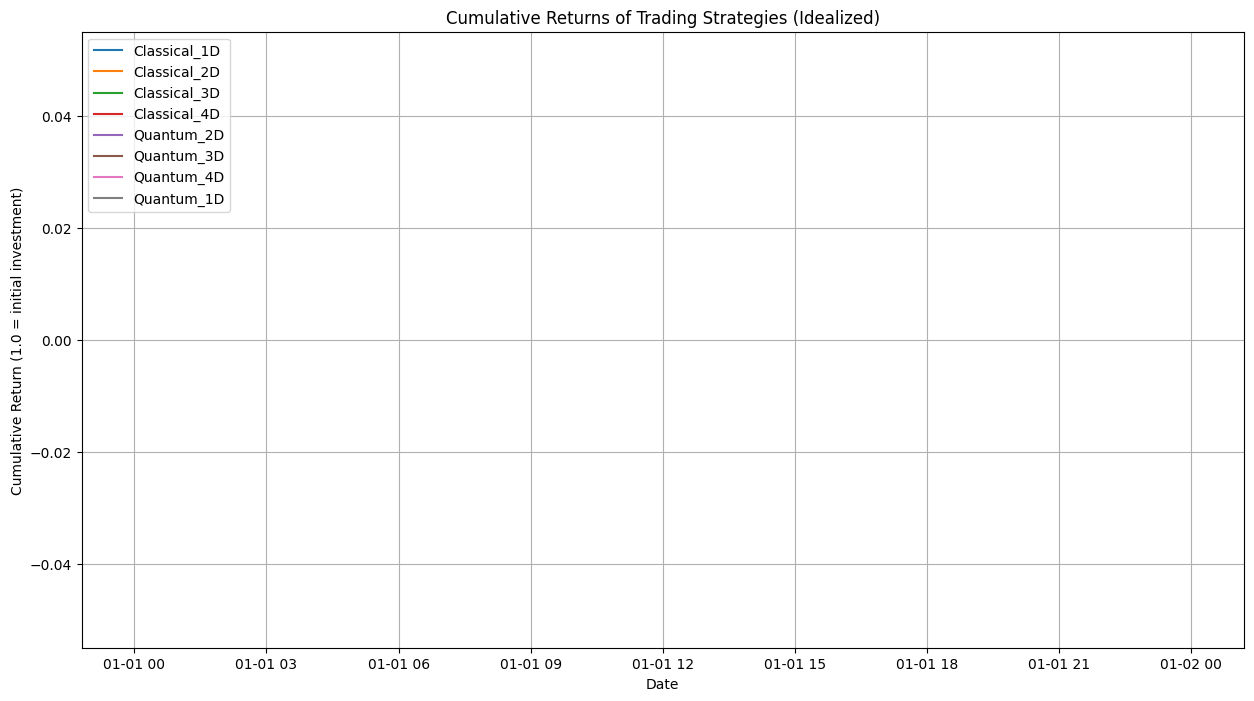


--- Detailed Trading Strategy Performance Analysis ---

========== Classical_1D ==========
--- Speed ---
  Prediction Gen Time (Total): 5.7625 sec
  Avg. Prediction Time / Point: 0.00000211 sec
--- Whole Dataset Performance ---
  Total Return: 0.00%
  Annualized Sharpe Ratio: 0.00
  Max Drawdown: 0.00%
--- Per-Trade Performance ---
  Number of Trades: 0
  Trades / Computation Second: 0.00
  (No trades executed)

========== Classical_2D ==========
--- Speed ---
  Prediction Gen Time (Total): 13.9996 sec
  Avg. Prediction Time / Point: 0.00000512 sec
--- Whole Dataset Performance ---
  Total Return: -0.05%
  Annualized Sharpe Ratio: -0.02
  Max Drawdown: -0.05%
--- Per-Trade Performance ---
  Number of Trades: 32
  Trades / Computation Second: 2.29
  Win Rate: 46.88%
  Profit Factor: 0.45
  Average Win: 0.0028%
  Average Loss: -0.0055%
  Average Trade Duration: 0 days 00:00:00.000000001

========== Classical_3D ==========
--- Speed ---
  Prediction Gen Time (Total): 38.3299 sec
  Avg. P

In [13]:
# Develop and compare trading strategies based on classical and quantum predictions
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time # Make sure time is imported


# --- Signal Generation  ---
def generate_signals(price_data, predictions, threshold=0.0001):
    """Generate trading signals based on price predictions"""
    signals = pd.DataFrame(index=price_data.index)
    # Ensure price_data index is datetime if possible for time calculations
    if not isinstance(price_data.index, pd.DatetimeIndex):
        try:
            price_data.index = pd.to_datetime(price_data.index)
            signals = pd.DataFrame(index=price_data.index) # Recreate with datetime index
        except:
            print("Warning: Could not convert price_data index to DatetimeIndex.")


    for model, pred_series in predictions.items():
        if not isinstance(pred_series, pd.Series):
            if len(pred_series) == len(price_data.index):
                 pred = pd.Series(pred_series, index=price_data.index)
            else:
                 print(f"Warning: Skipping signal generation for {model} due to length mismatch.")
                 continue
        else:
             # Align index and fill missing values
             pred = pred_series.reindex(price_data.index).ffill().bfill()

        pred_returns = pred.pct_change().fillna(0)
        signal_col = f'{model}_signal'
        signals[signal_col] = 0
        signals.loc[pred_returns > threshold, signal_col] = 1
        signals.loc[pred_returns < -threshold, signal_col] = -1

    return signals

# --- Modified Backtesting Function to Log Trades ---
def backtest_strategy_with_trade_log(price_data, signals, model_names):
    """
    Backtest trading strategy performance and log individual trades.
    Returns daily returns DataFrame and a dictionary of trade logs.
    """
    returns = pd.DataFrame(index=price_data.index)
    trade_logs = {model: [] for model in model_names} # Initialize dict for logs

    # Ensure price_data is a Series and has a numeric type
    if isinstance(price_data, pd.DataFrame):
         price_data = price_data.iloc[:, 0]
    price_data = pd.to_numeric(price_data, errors='coerce')
    price_returns = price_data.pct_change().fillna(0)

    for model in model_names:
        signal_col = f'{model}_signal'
        if signal_col not in signals.columns:
             print(f"Warning: Signal column {signal_col} not found. Skipping backtest for {model}.")
             returns[model] = 0
             returns[f'{model}_cumulative'] = 1.0
             continue

        # Align signals and fill NaNs
        aligned_signals = signals[signal_col].reindex(price_returns.index).ffill().fillna(0)
        shifted_signals = aligned_signals.shift(1).fillna(0)

        # Calculate daily returns based on previous day's signal
        strategy_returns = price_returns * shifted_signals
        returns[model] = strategy_returns
        returns[f'{model}_cumulative'] = (1 + strategy_returns).cumprod()

        # --- Per-Trade Logic ---
        position = 0 # 0: flat, 1: long, -1: short
        entry_price = 0
        entry_index = None
        current_trade_log = []

        for i in range(1, len(price_data)): # Start from 1 to use shift(1) signal
            current_signal = aligned_signals.iloc[i]
            prev_signal = shifted_signals.iloc[i] # Signal active for this period's return
            current_price = price_data.iloc[i]
            current_idx = price_data.index[i]

            # Check if position should change based on the signal *for the current period*
            # Exit condition: If we have a position and the signal flips or goes to zero
            if position != 0 and (current_signal != position):
                exit_price = current_price
                exit_index = current_idx
                if entry_price != 0: # Ensure valid entry price
                    trade_return_pct = (exit_price / entry_price - 1) * position # PnL %
                    duration = exit_index - entry_index if isinstance(entry_index, pd.Timestamp) and isinstance(exit_index, pd.Timestamp) else i - entry_index_num # Fallback to index diff

                    current_trade_log.append({
                        'entry_time': entry_index,
                        'exit_time': exit_index,
                        'entry_price': entry_price,
                        'exit_price': exit_price,
                        'position': position,
                        'return_pct': trade_return_pct,
                        'duration': duration
                    })
                position = 0 # Reset position
                entry_price = 0
                entry_index = None


            # Entry condition: If we are flat and the signal becomes non-zero
            if position == 0 and current_signal != 0:
                position = int(current_signal)
                entry_price = current_price
                entry_index = current_idx
                entry_index_num = i # Store index number as fallback

        # Close any open position at the end of the data
        if position != 0 and entry_price != 0:
             exit_price = price_data.iloc[-1]
             exit_index = price_data.index[-1]
             trade_return_pct = (exit_price / entry_price - 1) * position
             duration = exit_index - entry_index if isinstance(entry_index, pd.Timestamp) and isinstance(exit_index, pd.Timestamp) else len(price_data) - 1 - entry_index_num
             current_trade_log.append({
                 'entry_time': entry_index,
                 'exit_time': exit_index,
                 'entry_price': entry_price,
                 'exit_price': exit_price,
                 'position': position,
                 'return_pct': trade_return_pct,
                 'duration': duration
             })

        trade_logs[model] = current_trade_log # Store the log for this model

    return returns, trade_logs

# --- Main Execution and Analysis ---

# Combine predictions
all_predictions = {}
valid_classical_dims = [dim for dim in classical_denormalized.keys() if dim in classical_times]
valid_quantum_dims = [dim for dim in quantum_denormalized.keys() if dim in quantum_times]

for dim in valid_classical_dims:
    all_predictions[f'Classical_{dim}'] = classical_denormalized[dim]
for dim in valid_quantum_dims:
    all_predictions[f'Quantum_{dim}'] = quantum_denormalized[dim]

# Generate signals
signals = generate_signals(original_mid_price, all_predictions)

# Backtest strategies and get trade logs
model_names = list(all_predictions.keys())
backtest_results, trade_logs = backtest_strategy_with_trade_log(original_mid_price, signals, model_names)

# Plot cumulative returns
plt.figure(figsize=(15, 8))
timestamp_index = data['timestamp'].reindex(backtest_results.index).ffill().bfill()
for model in model_names:
    plt.plot(timestamp_index, backtest_results[f'{model}_cumulative'], label=model)
plt.title('Cumulative Returns of Trading Strategies (Idealized)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (1.0 = initial investment)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# --- Calculate and Print Detailed Metrics (Whole Dataset + Per Trade + Speed) ---
print("\n--- Detailed Trading Strategy Performance Analysis ---")

performance_summary = {}
num_data_points = len(original_mid_price)

for model in model_names:
    print(f"\n========== {model} ==========")
    parts = model.split('_')
    method = parts[0]
    dim_key = parts[1]

    # --- Speed Metrics ---
    if method == 'Classical':
        exec_time = classical_times.get(dim_key, float('nan'))
    else: # Quantum
        exec_time = quantum_times.get(dim_key, float('nan'))

    avg_time_per_point = exec_time / num_data_points if num_data_points > 0 and not np.isnan(exec_time) else float('nan')

    print(f"--- Speed ---")
    print(f"  Prediction Gen Time (Total): {exec_time:.4f} sec")
    print(f"  Avg. Prediction Time / Point: {avg_time_per_point:.8f} sec") # Higher precision

    # --- Whole Dataset Performance Metrics ---
    cumulative_returns = backtest_results[f'{model}_cumulative']
    daily_returns = backtest_results[model]
    total_return = cumulative_returns.iloc[-1] - 1 if not cumulative_returns.empty else 0
    sharpe = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if daily_returns.std() != 0 else 0 # Annualized Sharpe
    if not cumulative_returns.empty:
        running_max = cumulative_returns.cummax()
        drawdown = (cumulative_returns / running_max - 1).min()
    else:
        drawdown = float('nan')

    print(f"--- Whole Dataset Performance ---")
    print(f"  Total Return: {total_return*100:.2f}%")
    print(f"  Annualized Sharpe Ratio: {sharpe:.2f}")
    print(f"  Max Drawdown: {drawdown*100:.2f}%")

    # --- Per-Trade Performance Metrics ---
    model_trade_log = trade_logs.get(model, [])
    num_trades = len(model_trade_log)
    trades_per_comp_sec = num_trades / exec_time if exec_time > 0 and not np.isnan(exec_time) else float('inf')

    print(f"--- Per-Trade Performance ---")
    print(f"  Number of Trades: {num_trades}")
    print(f"  Trades / Computation Second: {trades_per_comp_sec:.2f}")

    if num_trades > 0:
        winning_trades = [t for t in model_trade_log if t['return_pct'] > 0]
        losing_trades = [t for t in model_trade_log if t['return_pct'] < 0]
        num_wins = len(winning_trades)
        num_losses = len(losing_trades)

        win_rate = num_wins / num_trades if num_trades > 0 else 0
        avg_win_pct = np.mean([t['return_pct'] for t in winning_trades]) * 100 if num_wins > 0 else 0
        avg_loss_pct = np.mean([t['return_pct'] for t in losing_trades]) * 100 if num_losses > 0 else 0

        total_profit_pct = sum(t['return_pct'] for t in winning_trades)
        total_loss_pct = abs(sum(t['return_pct'] for t in losing_trades))
        profit_factor = total_profit_pct / total_loss_pct if total_loss_pct > 0 else float('inf')

        # Avg duration requires datetime index
        valid_durations = [t['duration'] for t in model_trade_log if isinstance(t['duration'], pd.Timedelta)]
        avg_duration = np.mean(valid_durations) if valid_durations else "N/A (Index not Datetime?)"


        print(f"  Win Rate: {win_rate*100:.2f}%")
        print(f"  Profit Factor: {profit_factor:.2f}")
        print(f"  Average Win: {avg_win_pct:.4f}%")
        print(f"  Average Loss: {avg_loss_pct:.4f}%")
        print(f"  Average Trade Duration: {avg_duration}")

    else:
        print("  (No trades executed)")

    # Store for aggregation
    performance_summary[model] = {
        'return': total_return, 'sharpe': sharpe, 'drawdown': drawdown,
        'time': exec_time, 'avg_time_per_point': avg_time_per_point,
        'num_trades': num_trades, 'win_rate': win_rate if num_trades > 0 else 0,
        'profit_factor': profit_factor if num_trades > 0 and total_loss_pct > 0 else (float('inf') if num_trades > 0 else 0),
        'trades_per_comp_sec': trades_per_comp_sec
    }
    print("=" * (len(model) + 12))


# --- Aggregate Comparison Table ---
classical_models = [m for m in model_names if m.startswith('Classical')]
quantum_models = [m for m in model_names if m.startswith('Quantum')]

# Use np.nanmean for averaging
metrics_to_avg = ['return', 'sharpe', 'drawdown', 'time', 'avg_time_per_point',
                  'num_trades', 'win_rate', 'profit_factor', 'trades_per_comp_sec']
agg_results = {'Classical': {}, 'Quantum': {}}

for method, models in [('Classical', classical_models), ('Quantum', quantum_models)]:
    for metric in metrics_to_avg:
         # Handle inf values in profit_factor and trades_per_comp_sec before averaging
         values = [performance_summary[m][metric] for m in models if m in performance_summary]
         values = [v if np.isfinite(v) else np.nan for v in values] # Replace inf with nan for averaging
         agg_results[method][metric] = np.nanmean(values) if values else np.nan


print("\n--- Aggregate Performance Comparison (Averaged Across Dimensions) ---")
print(f"{'Metric':<25} | {'Classical Avg.':<15} | {'Quantum Avg.':<15} | {'Difference (Q-C)':<18}")
print("-" * 78)
print(f"{'Return (%)':<25} | {agg_results['Classical']['return']*100:15.2f} | {agg_results['Quantum']['return']*100:15.2f} | {(agg_results['Quantum']['return']-agg_results['Classical']['return'])*100:18.2f}")
print(f"{'Sharpe Ratio':<25} | {agg_results['Classical']['sharpe']:15.2f} | {agg_results['Quantum']['sharpe']:15.2f} | {(agg_results['Quantum']['sharpe']-agg_results['Classical']['sharpe']):18.2f}")
print(f"{'Max Drawdown (%)':<25} | {agg_results['Classical']['drawdown']*100:15.2f} | {agg_results['Quantum']['drawdown']*100:15.2f} | {(agg_results['Quantum']['drawdown']-agg_results['Classical']['drawdown'])*100:18.2f}")
print(f"{'Prediction Time (s)':<25} | {agg_results['Classical']['time']:15.4f} | {agg_results['Quantum']['time']:15.4f} | {(agg_results['Quantum']['time']-agg_results['Classical']['time']):18.4f}")
print(f"{'Avg Time/Point (s)':<25} | {agg_results['Classical']['avg_time_per_point']:15.8f} | {agg_results['Quantum']['avg_time_per_point']:15.8f} | {(agg_results['Quantum']['avg_time_per_point']-agg_results['Classical']['avg_time_per_point']):18.8f}")
print(f"{'Number of Trades':<25} | {agg_results['Classical']['num_trades']:15.1f} | {agg_results['Quantum']['num_trades']:15.1f} | {(agg_results['Quantum']['num_trades']-agg_results['Classical']['num_trades']):18.1f}")
print(f"{'Win Rate (%)':<25} | {agg_results['Classical']['win_rate']*100:15.2f} | {agg_results['Quantum']['win_rate']*100:15.2f} | {(agg_results['Quantum']['win_rate']-agg_results['Classical']['win_rate'])*100:18.2f}")
print(f"{'Profit Factor':<25} | {agg_results['Classical']['profit_factor']:15.2f} | {agg_results['Quantum']['profit_factor']:15.2f} | {(agg_results['Quantum']['profit_factor']-agg_results['Classical']['profit_factor']):18.2f}")
print(f"{'Trades / Comp Sec':<25} | {agg_results['Classical']['trades_per_comp_sec']:15.2f} | {agg_results['Quantum']['trades_per_comp_sec']:15.2f} | {(agg_results['Quantum']['trades_per_comp_sec']-agg_results['Classical']['trades_per_comp_sec']):18.2f}")
print("-" * 78)


# --- Final Discussion  ---
print("\n--- Speed vs. Performance Discussion (Extended) ---")
time_diff_per_point = agg_results['Classical']['avg_time_per_point'] - agg_results['Quantum']['avg_time_per_point']
perf_diff_return = agg_results['Quantum']['return'] - agg_results['Classical']['return']
perf_diff_pf = agg_results['Quantum']['profit_factor'] - agg_results['Classical']['profit_factor']
print(f"Avg. Time per Data Point: Quantum was {'faster' if time_diff_per_point > 0 else 'slower'} by {abs(time_diff_per_point):.8f} sec.")
print(f"Avg. Total Return: Quantum was {'higher' if perf_diff_return > 0 else 'lower'} by {abs(perf_diff_return)*100:.2f}%.")
print(f"Avg. Profit Factor: Quantum was {'higher' if perf_diff_pf > 0 else 'lower'} by {abs(perf_diff_pf):.2f}.")

# Add more  conclusions based on speed and performance metrics
if time_diff_per_point > 0: # Quantum faster per point
    if perf_diff_return > 0 and perf_diff_pf > 0:
        print("Conclusion: Quantum shows potential advantage in prediction speed (per point) and idealized trading outcomes (Return, Profit Factor).")
    elif perf_diff_return > 0 or perf_diff_pf > 0:
        print("Conclusion: Quantum shows potential speed advantage, with mixed results in idealized trading outcomes.")
    else:
        print("Conclusion: Quantum shows potential speed advantage, but classical performed better in idealized trading outcomes.")
else: # Classical faster or equal per point
    if perf_diff_return > 0 and perf_diff_pf > 0:
        print("Conclusion: Quantum shows potential advantage in idealized trading outcomes despite being slower per point.")
    elif perf_diff_return > 0 or perf_diff_pf > 0:
         print("Conclusion: Mixed results - Classical faster per point, Quantum showed some trading outcome advantage.")
    else:
        print("Conclusion: Classical performed better in both prediction speed (per point) and idealized trading outcomes.")


print("\nImportant Notes:")
print("- Trading simulation is highly idealized (no costs, latency, slippage, market impact).")
print("- 'Avg. Time per Data Point' is a proxy for potential update speed, calculated from total prediction time over the dataset.")
print("- 'Trades / Computation Second' relates trading activity to total prediction time.")
print("- Real-world HFT performance and speed dynamics would differ significantly.")